In [1]:
## 設定
verbose = False
check   = False

### 言語の割合の均等化
balanced = True

### LDA 用

## トピック数
n_topics = 10 # 30は多過ぎる？

## doc, term の設定
doc_type      = 'form'  # 変更不可
doc_attr      = 'sound' # spell か sound の選択
max_doc_size  = 12
##
term_size = 'character'
term_type = 'skippy2gram'
## skippy n-gram の結合範囲
max_distance_val = round(max_doc_size * 0.8)
print(f"max_distance_val: {max_distance_val}")

## ngram を包括的にするかどうか
ngram_is_inclusive = True

### DTM 構築

## term の最低頻度
term_min_freq = 2

## 高頻度 term の濫用指標: 大きくし過ぎないように．0.05 は十分に大きい
term_abuse_threshold = 0.04

max_distance_val: 10


In [2]:
import sys, os, random, re, glob
import pandas as pd
import pprint as pp
from functools import reduce

In [3]:
## load data to process
from pathlib import Path
import pprint as pp

wd = Path(".")
dirs = [ x for x in wd.iterdir() if x.is_dir() and not x.match(r"plot*") ]
if verbose:
    print(f"The following {len(dirs)} directories are potential targets:")
    pp.pprint(dirs)

## list up files in target directory 
wd = Path(".")
target_dir = "data-words" # can be changed
target_files = sorted(list(wd.glob(f"{target_dir}/*.csv")))
#
print(f"\n{target_dir} contains {len(target_files)} files to process")
pp.pprint(target_files)


data-words contains 25 files to process
[PosixPath('data-words/base-sound-Arabic-r0-1k-mc.csv'),
 PosixPath('data-words/base-sound-English-r6e-original.csv'),
 PosixPath('data-words/base-sound-French-r0-1k-mc.csv'),
 PosixPath('data-words/base-sound-French-r0-opendic-s900.csv'),
 PosixPath('data-words/base-sound-German-r1a-original.csv'),
 PosixPath('data-words/base-sound-Icelandic-r0-1k-mc.csv'),
 PosixPath('data-words/base-sound-Spanish-r0-1k-mc.csv'),
 PosixPath('data-words/base-sound-Swahili-r0-1k-mc.csv'),
 PosixPath('data-words/base-spell-Arabic-r0-1k-mc.csv'),
 PosixPath('data-words/base-spell-Chinese-r0-1k-mc.csv'),
 PosixPath('data-words/base-spell-English-r6e-original.csv'),
 PosixPath('data-words/base-spell-Esperanto-r0-orginal.csv'),
 PosixPath('data-words/base-spell-Finnish-r0-1k-mc.csv'),
 PosixPath('data-words/base-spell-French-r0-1k-mc.csv'),
 PosixPath('data-words/base-spell-German-r1a-original.csv'),
 PosixPath('data-words/base-spell-Greek-r0-1k-mc.csv'),
 PosixPath(

In [4]:
import pandas as pd

## データ型の辞書
types = re.split(r",\s+", "spell, sound, freq")
type_settings = { t : 0 for t in types }
print(type_settings)

## 言語名の辞書
lang_name_text = "arabic, bengali, chinese, english, esperanto, finnish, french, \
greek, galician, german, hungarian, icelandic, irish, italian, japanese, russian, spanish, swahili, turkish"

langs = re.split(r",\s*", lang_name_text)
#langs = "english esperanto french german russian swahili".split(" ")
#langs = "english esperanto french german icelandic swahili".split(" ")
lang_settings = { lang : 0 for lang in langs }
print(f"{len(lang_settings.keys())} langs are available")
print(lang_settings)

## 辞書と統合
settings = { 'form': None, **type_settings, **lang_settings }
print(settings)

{'spell': 0, 'sound': 0, 'freq': 0}
19 langs are available
{'arabic': 0, 'bengali': 0, 'chinese': 0, 'english': 0, 'esperanto': 0, 'finnish': 0, 'french': 0, 'greek': 0, 'galician': 0, 'german': 0, 'hungarian': 0, 'icelandic': 0, 'irish': 0, 'italian': 0, 'japanese': 0, 'russian': 0, 'spanish': 0, 'swahili': 0, 'turkish': 0}
{'form': None, 'spell': 0, 'sound': 0, 'freq': 0, 'arabic': 0, 'bengali': 0, 'chinese': 0, 'english': 0, 'esperanto': 0, 'finnish': 0, 'french': 0, 'greek': 0, 'galician': 0, 'german': 0, 'hungarian': 0, 'icelandic': 0, 'irish': 0, 'italian': 0, 'japanese': 0, 'russian': 0, 'spanish': 0, 'swahili': 0, 'turkish': 0}


In [5]:
check = False

vars = list(settings.keys())
print(f"targe var names: {vars}")
d_parts = [ ]
for lang in langs:
    local_settings = settings.copy()
    if check:
        print(f"processing: {lang}")
    try:
        for f in [ f for f in target_files if lang.capitalize() in str(f) ]:
            print(f"reading: {f}")
            # 言語名の指定
            local_settings[lang] = 1
            # 型名の指定
            for type in vars:
                if type in str(f):
                    local_settings[type] = 1
            #
            try:
                d = pd.read_csv(f, encoding='utf-8', sep = ",", on_bad_lines = 'skip') # Crucially, ...= skip
                df = pd.DataFrame(d, columns = vars)
                for var in [ var for var in (types + langs) if var != 'freq' ]:
                    df[var] = local_settings[var]
                d_parts.append(df)
            except FileNotFoundError:
                pass
    except IndexError:
        pass
#
if verbose:
    d_parts

targe var names: ['form', 'spell', 'sound', 'freq', 'arabic', 'bengali', 'chinese', 'english', 'esperanto', 'finnish', 'french', 'greek', 'galician', 'german', 'hungarian', 'icelandic', 'irish', 'italian', 'japanese', 'russian', 'spanish', 'swahili', 'turkish']
reading: data-words/base-sound-Arabic-r0-1k-mc.csv
reading: data-words/base-spell-Arabic-r0-1k-mc.csv
reading: data-words/base-spell-Chinese-r0-1k-mc.csv
reading: data-words/base-sound-English-r6e-original.csv
reading: data-words/base-spell-English-r6e-original.csv
reading: data-words/base-spell-Esperanto-r0-orginal.csv
reading: data-words/base-spell-Finnish-r0-1k-mc.csv
reading: data-words/base-sound-French-r0-1k-mc.csv
reading: data-words/base-sound-French-r0-opendic-s900.csv
reading: data-words/base-spell-French-r0-1k-mc.csv
reading: data-words/base-spell-Greek-r0-1k-mc.csv
reading: data-words/base-sound-German-r1a-original.csv
reading: data-words/base-spell-German-r1a-original.csv
reading: data-words/base-spell-Hungarian-r0-

In [6]:
## データ統合

raw_df = pd.concat(d_parts)
raw_df

form  spell  sound freq  arabic  bengali  chinese  english  esperanto  \
0    kamaː      0      1    1       1        0        0        0          0   
1    ʔanaː      0      1    1       1        0        0        0          0   
2     lahu      0      1    1       1        0        0        0          0   
3      ʔan      0      1    1       1        0        0        0          0   
4     huːa      0      1    1       1        0        0        0          0   
..     ...    ...    ...  ...     ...      ...      ...      ...        ...   
994  burun      1      0    1       0        0        0        0          0   
995  çoğul      1      0    1       0        0        0        0          0   
996   öfke      1      0    1       0        0        0        0          0   
997  iddia      1      0    1       0        0        0        0          0   
998   kıta      1      0    1       0        0        0        0          0   

     finnish  ...  german  hungarian  icelandic  irish  italian  japanese  \
0          0  ...       0          0          0      0        0         0   
1          0  ...       0          0          0      0        0         0   
2          0  ...       0          0          0      0        0         0   
3          0  ...       0          0          0      0        0         0   
4          0  ...       0          0          0      0        0         0   
..       ...  ...     ...        ...        ...    ...      ...       ...   
994        0  ...       0          0          0      0        0         0   
995        0  ...       0          0          0      0        0         0   
996        0  ...       0          0          0      0        0         0   
997        0  ...       0          0          0      0        0         0   
998        0  ...       0          0          0      0        0         0   

     russian  spanish  swahili  turkish  
0          0        0        0        0  
1          0        0        0        0  
2          0        0        0        0  
3          0        0        0        0  
4          0        0        0        0  
..       ...      ...      ...      ...  
994        0        0        0        1  
995        0        0        0        1  
996        0        0        0        1  
997        0        0        0        1  
998        0        0        0        1  

[28858 rows x 23 columns]

In [7]:
## 文字数の列を追加

raw_df['size'] = [ len(x) for x in raw_df[doc_type] ]
raw_df

form  spell  sound freq  arabic  bengali  chinese  english  esperanto  \
0    kamaː      0      1    1       1        0        0        0          0   
1    ʔanaː      0      1    1       1        0        0        0          0   
2     lahu      0      1    1       1        0        0        0          0   
3      ʔan      0      1    1       1        0        0        0          0   
4     huːa      0      1    1       1        0        0        0          0   
..     ...    ...    ...  ...     ...      ...      ...      ...        ...   
994  burun      1      0    1       0        0        0        0          0   
995  çoğul      1      0    1       0        0        0        0          0   
996   öfke      1      0    1       0        0        0        0          0   
997  iddia      1      0    1       0        0        0        0          0   
998   kıta      1      0    1       0        0        0        0          0   

     finnish  ...  hungarian  icelandic  irish  italian  japanese  russian  \
0          0  ...          0          0      0        0         0        0   
1          0  ...          0          0      0        0         0        0   
2          0  ...          0          0      0        0         0        0   
3          0  ...          0          0      0        0         0        0   
4          0  ...          0          0      0        0         0        0   
..       ...  ...        ...        ...    ...      ...       ...      ...   
994        0  ...          0          0      0        0         0        0   
995        0  ...          0          0      0        0         0        0   
996        0  ...          0          0      0        0         0        0   
997        0  ...          0          0      0        0         0        0   
998        0  ...          0          0      0        0         0        0   

     spanish  swahili  turkish  size  
0          0        0        0     5  
1          0        0        0     5  
2          0        0        0     4  
3          0        0        0     3  
4          0        0        0     4  
..       ...      ...      ...   ...  
994        0        0        1     5  
995        0        0        1     5  
996        0        0        1     4  
997        0        0        1     5  
998        0        0        1     4  

[28858 rows x 24 columns]

In [8]:
## 言語名= language の列を追加

check = False
language_vals = [ ]
for i, row in raw_df.iterrows():
    if check:
        print(row)
    for j, lang in enumerate(langs):
        if check:
            print(f"{i}: {lang}")
        if row[lang] == 1:
            language_vals.append(lang)
if verbose:
    print(language_vals)
    len(language_vals)
#
raw_df['language'] = language_vals
raw_df

form  spell  sound freq  arabic  bengali  chinese  english  esperanto  \
0    kamaː      0      1    1       1        0        0        0          0   
1    ʔanaː      0      1    1       1        0        0        0          0   
2     lahu      0      1    1       1        0        0        0          0   
3      ʔan      0      1    1       1        0        0        0          0   
4     huːa      0      1    1       1        0        0        0          0   
..     ...    ...    ...  ...     ...      ...      ...      ...        ...   
994  burun      1      0    1       0        0        0        0          0   
995  çoğul      1      0    1       0        0        0        0          0   
996   öfke      1      0    1       0        0        0        0          0   
997  iddia      1      0    1       0        0        0        0          0   
998   kıta      1      0    1       0        0        0        0          0   

     finnish  ...  icelandic  irish  italian  japanese  russian  spanish  \
0          0  ...          0      0        0         0        0        0   
1          0  ...          0      0        0         0        0        0   
2          0  ...          0      0        0         0        0        0   
3          0  ...          0      0        0         0        0        0   
4          0  ...          0      0        0         0        0        0   
..       ...  ...        ...    ...      ...       ...      ...      ...   
994        0  ...          0      0        0         0        0        0   
995        0  ...          0      0        0         0        0        0   
996        0  ...          0      0        0         0        0        0   
997        0  ...          0      0        0         0        0        0   
998        0  ...          0      0        0         0        0        0   

     swahili  turkish  size  language  
0          0        0     5    arabic  
1          0        0     5    arabic  
2          0        0     4    arabic  
3          0        0     3    arabic  
4          0        0     4    arabic  
..       ...      ...   ...       ...  
994        0        1     5   turkish  
995        0        1     5   turkish  
996        0        1     4   turkish  
997        0        1     5   turkish  
998        0        1     4   turkish  

[28858 rows x 25 columns]

In [9]:
## データ型の指定

raw_df = raw_df[raw_df[doc_attr] == 1]
print(f"doc_attr: {doc_attr}")
raw_df

doc_attr: sound


form  spell  sound freq  arabic  bengali  chinese  english  esperanto  \
0    kamaː      0      1    1       1        0        0        0          0   
1    ʔanaː      0      1    1       1        0        0        0          0   
2     lahu      0      1    1       1        0        0        0          0   
3      ʔan      0      1    1       1        0        0        0          0   
4     huːa      0      1    1       1        0        0        0          0   
..     ...    ...    ...  ...     ...      ...      ...      ...        ...   
703  zaidi      1      1    1       0        0        0        0          0   
704  ziara      1      1    1       0        0        0        0          0   
705   zima      1      1    1       0        0        0        0          0   
706   ziwa      1      1    1       0        0        0        0          0   
707  zoezi      1      1    1       0        0        0        0          0   

     finnish  ...  icelandic  irish  italian  japanese  russian  spanish  \
0          0  ...          0      0        0         0        0        0   
1          0  ...          0      0        0         0        0        0   
2          0  ...          0      0        0         0        0        0   
3          0  ...          0      0        0         0        0        0   
4          0  ...          0      0        0         0        0        0   
..       ...  ...        ...    ...      ...       ...      ...      ...   
703        0  ...          0      0        0         0        0        0   
704        0  ...          0      0        0         0        0        0   
705        0  ...          0      0        0         0        0        0   
706        0  ...          0      0        0         0        0        0   
707        0  ...          0      0        0         0        0        0   

     swahili  turkish  size  language  
0          0        0     5    arabic  
1          0        0     5    arabic  
2          0        0     4    arabic  
3          0        0     3    arabic  
4          0        0     4    arabic  
..       ...      ...   ...       ...  
703        1        0     5   swahili  
704        1        0     5   swahili  
705        1        0     4   swahili  
706        1        0     4   swahili  
707        1        0     5   swahili  

[19162 rows x 25 columns]

In [10]:
## 言語の選別

select_languages = True

#selected_langs = re.split(r",\s*", "english, french, german, russian, swahili")
selected_langs = re.split(r",\s*",
                          "arabic, bengali, chinese, english, french, german, \
                          greek, hungarian, icelandic, russian, japanese, turkish")

print(f"selected languages: {selected_langs}")

if select_languages:
    df_new = [ ]
    for lang in selected_langs:
        df_new.append(raw_df[raw_df[lang] == 1])
    raw_df = pd.concat(df_new)
#
raw_df

selected languages: ['arabic', 'bengali', 'chinese', 'english', 'french', 'german', 'greek', 'hungarian', 'icelandic', 'russian', 'japanese', 'turkish']


form  spell  sound freq  arabic  bengali  chinese  english  esperanto  \
0      kamaː      0      1    1       1        0        0        0          0   
1      ʔanaː      0      1    1       1        0        0        0          0   
2       lahu      0      1    1       1        0        0        0          0   
3        ʔan      0      1    1       1        0        0        0          0   
4       huːa      0      1    1       1        0        0        0          0   
..       ...    ...    ...  ...     ...      ...      ...      ...        ...   
844     ætti      1      1    1       0        0        0        0          0   
845      öld      1      1    1       0        0        0        0          0   
846      önd      1      1    1       0        0        0        0          0   
847  öruggur      1      1    1       0        0        0        0          0   
848      öxl      1      1    1       0        0        0        0          0   

     finnish  ...  icelandic  irish  italian  japanese  russian  spanish  \
0          0  ...          0      0        0         0        0        0   
1          0  ...          0      0        0         0        0        0   
2          0  ...          0      0        0         0        0        0   
3          0  ...          0      0        0         0        0        0   
4          0  ...          0      0        0         0        0        0   
..       ...  ...        ...    ...      ...       ...      ...      ...   
844        0  ...          1      0        0         0        0        0   
845        0  ...          1      0        0         0        0        0   
846        0  ...          1      0        0         0        0        0   
847        0  ...          1      0        0         0        0        0   
848        0  ...          1      0        0         0        0        0   

     swahili  turkish  size   language  
0          0        0     5     arabic  
1          0        0     5     arabic  
2          0        0     4     arabic  
3          0        0     3     arabic  
4          0        0     4     arabic  
..       ...      ...   ...        ...  
844        0        0     4  icelandic  
845        0        0     3  icelandic  
846        0        0     3  icelandic  
847        0        0     7  icelandic  
848        0        0     3  icelandic  

[15616 rows x 25 columns]

/var/folders/7s/_syxn0dd45lcngw4yl2kywd40000gn/T/ipykernel_26215/1088473461.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


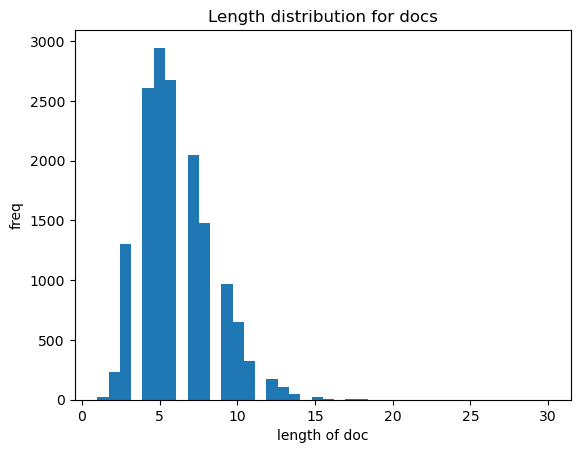

In [11]:
## 文字数の分布
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.hist(raw_df['size'], bins = 40)
ax.set_xlabel('length of doc')
ax.set_ylabel('freq')
plt.title(f"Length distribution for docs")
fig.show()

In [12]:
## 長さで濾過

print(f"max doc size: {max_doc_size}")
original_size = len(raw_df)
raw_df = raw_df[raw_df['size'] < max_doc_size]
filtered_size = len(raw_df)
print(f"{original_size - filtered_size} cases removed")

max doc size: 12
365 cases removed


In [13]:
## 結果の検査 1

for lang in langs:
    print(raw_df[lang].value_counts())

arabic
0    13532
1     1719
Name: count, dtype: int64
bengali
0    15251
Name: count, dtype: int64
chinese
0    15251
Name: count, dtype: int64
english
1    8249
0    7002
Name: count, dtype: int64
esperanto
0    15251
Name: count, dtype: int64
finnish
0    15251
Name: count, dtype: int64
french
0    13307
1     1944
Name: count, dtype: int64
greek
0    15251
Name: count, dtype: int64
galician
0    15251
Name: count, dtype: int64
german
0    13686
1     1565
Name: count, dtype: int64
hungarian
0    15251
Name: count, dtype: int64
icelandic
0    13477
1     1774
Name: count, dtype: int64
irish
0    15251
Name: count, dtype: int64
italian
0    15251
Name: count, dtype: int64
japanese
0    15251
Name: count, dtype: int64
russian
0    15251
Name: count, dtype: int64
spanish
0    15251
Name: count, dtype: int64
swahili
0    15251
Name: count, dtype: int64
turkish
0    15251
Name: count, dtype: int64


In [14]:
## 結果の検査 2

for type in types:
    print(raw_df[type].value_counts())

spell
1    7750
0    7501
Name: count, dtype: int64
sound
1    15251
Name: count, dtype: int64
freq
1    15205
Name: count, dtype: int64


In [15]:
## 統合: 割合補正を適用

eng_reduct_factor = 0.2
if balanced:
    eng_df = raw_df[raw_df['english'] == 1]
    non_eng_df = raw_df[raw_df['english'] == 0]
    eng_reduced_df = eng_df.sample(round(len(eng_df) * eng_reduct_factor))
    raw_df = pd.concat([eng_reduced_df, non_eng_df])
raw_df

form  spell  sound freq  arabic  bengali  chinese  english  \
1920    nɔɹməl      0      1    1       0        0        0        1   
2036       joy      1      1  1.0       0        0        0        1   
3847     throw      1      1  1.0       0        0        0        1   
3727    system      1      1  1.0       0        0        0        1   
1940  oʊnəɹʃɪp      0      1    1       0        0        0        1   
...        ...    ...    ...  ...     ...      ...      ...      ...   
844       ætti      1      1    1       0        0        0        0   
845        öld      1      1    1       0        0        0        0   
846        önd      1      1    1       0        0        0        0   
847    öruggur      1      1    1       0        0        0        0   
848        öxl      1      1    1       0        0        0        0   

      esperanto  finnish  ...  icelandic  irish  italian  japanese  russian  \
1920          0        0  ...          0      0        0         0        0   
2036          0        0  ...          0      0        0         0        0   
3847          0        0  ...          0      0        0         0        0   
3727          0        0  ...          0      0        0         0        0   
1940          0        0  ...          0      0        0         0        0   
...         ...      ...  ...        ...    ...      ...       ...      ...   
844           0        0  ...          1      0        0         0        0   
845           0        0  ...          1      0        0         0        0   
846           0        0  ...          1      0        0         0        0   
847           0        0  ...          1      0        0         0        0   
848           0        0  ...          1      0        0         0        0   

      spanish  swahili  turkish  size   language  
1920        0        0        0     6    english  
2036        0        0        0     3    english  
3847        0        0        0     5    english  
3727        0        0        0     6    english  
1940        0        0        0     8    english  
...       ...      ...      ...   ...        ...  
844         0        0        0     4  icelandic  
845         0        0        0     3  icelandic  
846         0        0        0     3  icelandic  
847         0        0        0     7  icelandic  
848         0        0        0     3  icelandic  

[8652 rows x 25 columns]

In [16]:
## 結果の検査 3

for lang in langs:
    print(raw_df[lang].value_counts())

arabic
0    6933
1    1719
Name: count, dtype: int64
bengali
0    8652
Name: count, dtype: int64
chinese
0    8652
Name: count, dtype: int64
english
0    7002
1    1650
Name: count, dtype: int64
esperanto
0    8652
Name: count, dtype: int64
finnish
0    8652
Name: count, dtype: int64
french
0    6708
1    1944
Name: count, dtype: int64
greek
0    8652
Name: count, dtype: int64
galician
0    8652
Name: count, dtype: int64
german
0    7087
1    1565
Name: count, dtype: int64
hungarian
0    8652
Name: count, dtype: int64
icelandic
0    6878
1    1774
Name: count, dtype: int64
irish
0    8652
Name: count, dtype: int64
italian
0    8652
Name: count, dtype: int64
japanese
0    8652
Name: count, dtype: int64
russian
0    8652
Name: count, dtype: int64
spanish
0    8652
Name: count, dtype: int64
swahili
0    8652
Name: count, dtype: int64
turkish
0    8652
Name: count, dtype: int64


# 解析

In [17]:
## 順序のランダマイズし，基本データを決定

import sklearn.utils
df = sklearn.utils.shuffle(raw_df)

In [18]:
## ngram の追加

import sys
sys.path.append('..')

import re
import ngrams
import importlib
importlib.reload(ngrams)
import ngrams_skippy

bases = df[doc_type]

## 1gram 列の追加
#sep = r""
#unigrams = [ list(filter(lambda x: len(x) > 0, y)) for y in [ re.split(sep, z) for z in bases ] ]
unigrams = ngrams.gen_unigrams(bases, sep = r"", check = False)
if verbose:
    random.sample(unigrams, 5)
#
df['1gram'] = unigrams
#df.loc[:,'1gram'] = unigrams
df

form  spell  sound freq  arabic  bengali  chinese  english  \
726      schiene      1      1    1       0        0        0        0   
163       flügel      1      1    1       0        0        0        0   
838   baʁagwinas      0      1    1       0        0        0        0   
179      ferskur      1      1    1       0        0        0        0   
732       الساحل      1      1  1.0       1        0        0        0   
...          ...    ...    ...  ...     ...      ...      ...      ...   
140       fɪʁmaː      0      1    1       0        0        0        0   
106         ʒɛst      0      1    1       0        0        0        0   
303        fille      1      1    1       0        0        0        0   
580        العمل      1      1  1.0       1        0        0        0   
1850     humfrey      1      1  1.0       0        0        0        1   

      esperanto  finnish  ...  irish  italian  japanese  russian  spanish  \
726           0        0  ...      0        0         0        0        0   
163           0        0  ...      0        0         0        0        0   
838           0        0  ...      0        0         0        0        0   
179           0        0  ...      0        0         0        0        0   
732           0        0  ...      0        0         0        0        0   
...         ...      ...  ...    ...      ...       ...      ...      ...   
140           0        0  ...      0        0         0        0        0   
106           0        0  ...      0        0         0        0        0   
303           0        0  ...      0        0         0        0        0   
580           0        0  ...      0        0         0        0        0   
1850          0        0  ...      0        0         0        0        0   

      swahili  turkish  size   language                           1gram  
726         0        0     7     german           [s, c, h, i, e, n, e]  
163         0        0     6     german              [f, l, ü, g, e, l]  
838         0        0    10     french  [b, a, ʁ, a, g, w, i, n, a, s]  
179         0        0     7  icelandic           [f, e, r, s, k, u, r]  
732         0        0     6     arabic              [ا, ل, س, ا, ح, ل]  
...       ...      ...   ...        ...                             ...  
140         0        0     6     german              [f, ɪ, ʁ, m, a, ː]  
106         0        0     4     french                    [ʒ, ɛ, s, t]  
303         0        0     5     french                 [f, i, l, l, e]  
580         0        0     5     arabic                 [ا, ل, ع, م, ل]  
1850        0        0     7    english           [h, u, m, f, r, e, y]  

[8652 rows x 26 columns]

In [19]:
## 2gram列の追加

bigrams = ngrams.gen_bigrams(bases, sep = r"", check = False)

## 包括的 2gram の作成
if ngram_is_inclusive:
    bigrams = [ [*b, *u] for b, u in zip(bigrams, unigrams) ]

if verbose:
    print(random.sample(bigrams, 3))

In [20]:
df['2gram'] = bigrams
if verbose:
    df

In [21]:
## 3gram列の追加

trigrams = ngrams.gen_trigrams(bases, sep = r"", check = False)

## 包括的 3gram の作成
if ngram_is_inclusive:
    trigrams = [ [ *t, *b ] for t, b in  zip(trigrams, bigrams) ]

if verbose:
    print(random.sample(trigrams, 3))

In [22]:
df['3gram'] = trigrams
if verbose:
    df

In [23]:
## skippy 2grams の生成

import sys
sys.path.append("..") # library path に一つ上の階層を追加

import ngrams_skippy

skippy_2grams = [ ngrams_skippy.generate_skippy_bigrams(x,
                                                         missing_mark = '…',
                                                         max_distance = max_distance_val, check = False)
                  for x in df['1gram'] ]

## 包括的 skippy 2-grams の生成
if ngram_is_inclusive:
    for i, b2 in enumerate(skippy_2grams):
        b2.extend(unigrams[i])
#
if verbose:
    random.sample(skippy_2grams, 3)

In [24]:
## skippy 2gram 列の追加

df['skippy2gram'] = skippy_2grams
df

form  spell  sound freq  arabic  bengali  chinese  english  \
726      schiene      1      1    1       0        0        0        0   
163       flügel      1      1    1       0        0        0        0   
838   baʁagwinas      0      1    1       0        0        0        0   
179      ferskur      1      1    1       0        0        0        0   
732       الساحل      1      1  1.0       1        0        0        0   
...          ...    ...    ...  ...     ...      ...      ...      ...   
140       fɪʁmaː      0      1    1       0        0        0        0   
106         ʒɛst      0      1    1       0        0        0        0   
303        fille      1      1    1       0        0        0        0   
580        العمل      1      1  1.0       1        0        0        0   
1850     humfrey      1      1  1.0       0        0        0        1   

      esperanto  finnish  ...  russian  spanish  swahili  turkish  size  \
726           0        0  ...        0        0        0        0     7   
163           0        0  ...        0        0        0        0     6   
838           0        0  ...        0        0        0        0    10   
179           0        0  ...        0        0        0        0     7   
732           0        0  ...        0        0        0        0     6   
...         ...      ...  ...      ...      ...      ...      ...   ...   
140           0        0  ...        0        0        0        0     6   
106           0        0  ...        0        0        0        0     4   
303           0        0  ...        0        0        0        0     5   
580           0        0  ...        0        0        0        0     5   
1850          0        0  ...        0        0        0        0     7   

       language                           1gram  \
726      german           [s, c, h, i, e, n, e]   
163      german              [f, l, ü, g, e, l]   
838      french  [b, a, ʁ, a, g, w, i, n, a, s]   
179   icelandic           [f, e, r, s, k, u, r]   
732      arabic              [ا, ل, س, ا, ح, ل]   
...         ...                             ...   
140      german              [f, ɪ, ʁ, m, a, ː]   
106      french                    [ʒ, ɛ, s, t]   
303      french                 [f, i, l, l, e]   
580      arabic                 [ا, ل, ع, م, ل]   
1850    english           [h, u, m, f, r, e, y]   

                                                  2gram  \
726       [sc, ch, hi, ie, en, ne, s, c, h, i, e, n, e]   
163              [fl, lü, üg, ge, el, f, l, ü, g, e, l]   
838   [ba, aʁ, ʁa, ag, gw, wi, in, na, as, b, a, ʁ, ...   
179       [fe, er, rs, sk, ku, ur, f, e, r, s, k, u, r]   
732              [ال, لس, سا, اح, حل, ا, ل, س, ا, ح, ل]   
...                                                 ...   
140              [fɪ, ɪʁ, ʁm, ma, aː, f, ɪ, ʁ, m, a, ː]   
106                            [ʒɛ, ɛs, st, ʒ, ɛ, s, t]   
303                     [fi, il, ll, le, f, i, l, l, e]   
580                     [ال, لع, عم, مل, ا, ل, ع, م, ل]   
1850      [hu, um, mf, fr, re, ey, h, u, m, f, r, e, y]   

                                                  3gram  \
726   [sch, chi, hie, ien, ene, sc, ch, hi, ie, en, ...   
163   [flü, lüg, üge, gel, fl, lü, üg, ge, el, f, l,...   
838   [baʁ, aʁa, ʁag, agw, gwi, win, ina, nas, ba, a...   
179   [fer, ers, rsk, sku, kur, fe, er, rs, sk, ku, ...   
732   [الس, لسا, ساح, احل, ال, لس, سا, اح, حل, ا, ل,...   
...                                                 ...   
140   [fɪʁ, ɪʁm, ʁma, maː, fɪ, ɪʁ, ʁm, ma, aː, f, ɪ,...   
106                  [ʒɛs, ɛst, ʒɛ, ɛs, st, ʒ, ɛ, s, t]   
303      [fil, ill, lle, fi, il, ll, le, f, i, l, l, e]   
580      [الع, لعم, عمل, ال, لع, عم, مل, ا, ل, ع, م, ل]   
1850  [hum, umf, mfr, fre, rey, hu, um, mf, fr, re, ...   

                                            skippy2gram  
726   [sc, s…h, s…i, s…e, s…n, ch, c…i, c…e, c…n, hi...  
163   [fl, f…ü, f…g, f…e, f…l, lü, l…g, l…e, l…l, üg...  
838   [ba, b…ʁ, b

In [25]:
## skippy 3grams の生成

#import sys
#sys.path.append("..") # library path に一つ上の階層を追加

import ngrams_skippy

skippy_3grams = [ ngrams_skippy.generate_skippy_trigrams(x,
                                                         missing_mark = '…',
                                                         max_distance = max_distance_val, check = False)
                  for x in df['1gram'] ]

## 包括的 skippy 3-grams の生成
if ngram_is_inclusive:
    for i, t2 in enumerate(skippy_3grams):
        t2.extend(skippy_2grams[i])
#
if verbose:
    random.sample(skippy_3grams, 3)

In [26]:
## skippy 3gram 列の追加

df['skippy3gram'] = skippy_3grams
df

form  spell  sound freq  arabic  bengali  chinese  english  \
726      schiene      1      1    1       0        0        0        0   
163       flügel      1      1    1       0        0        0        0   
838   baʁagwinas      0      1    1       0        0        0        0   
179      ferskur      1      1    1       0        0        0        0   
732       الساحل      1      1  1.0       1        0        0        0   
...          ...    ...    ...  ...     ...      ...      ...      ...   
140       fɪʁmaː      0      1    1       0        0        0        0   
106         ʒɛst      0      1    1       0        0        0        0   
303        fille      1      1    1       0        0        0        0   
580        العمل      1      1  1.0       1        0        0        0   
1850     humfrey      1      1  1.0       0        0        0        1   

      esperanto  finnish  ...  spanish  swahili  turkish  size   language  \
726           0        0  ...        0        0        0     7     german   
163           0        0  ...        0        0        0     6     german   
838           0        0  ...        0        0        0    10     french   
179           0        0  ...        0        0        0     7  icelandic   
732           0        0  ...        0        0        0     6     arabic   
...         ...      ...  ...      ...      ...      ...   ...        ...   
140           0        0  ...        0        0        0     6     german   
106           0        0  ...        0        0        0     4     french   
303           0        0  ...        0        0        0     5     french   
580           0        0  ...        0        0        0     5     arabic   
1850          0        0  ...        0        0        0     7    english   

                               1gram  \
726            [s, c, h, i, e, n, e]   
163               [f, l, ü, g, e, l]   
838   [b, a, ʁ, a, g, w, i, n, a, s]   
179            [f, e, r, s, k, u, r]   
732               [ا, ل, س, ا, ح, ل]   
...                              ...   
140               [f, ɪ, ʁ, m, a, ː]   
106                     [ʒ, ɛ, s, t]   
303                  [f, i, l, l, e]   
580                  [ا, ل, ع, م, ل]   
1850           [h, u, m, f, r, e, y]   

                                                  2gram  \
726       [sc, ch, hi, ie, en, ne, s, c, h, i, e, n, e]   
163              [fl, lü, üg, ge, el, f, l, ü, g, e, l]   
838   [ba, aʁ, ʁa, ag, gw, wi, in, na, as, b, a, ʁ, ...   
179       [fe, er, rs, sk, ku, ur, f, e, r, s, k, u, r]   
732              [ال, لس, سا, اح, حل, ا, ل, س, ا, ح, ل]   
...                                                 ...   
140              [fɪ, ɪʁ, ʁm, ma, aː, f, ɪ, ʁ, m, a, ː]   
106                            [ʒɛ, ɛs, st, ʒ, ɛ, s, t]   
303                     [fi, il, ll, le, f, i, l, l, e]   
580                     [ال, لع, عم, مل, ا, ل, ع, م, ل]   
1850      [hu, um, mf, fr, re, ey, h, u, m, f, r, e, y]   

                                                  3gram  \
726   [sch, chi, hie, ien, ene, sc, ch, hi, ie, en, ...   
163   [flü, lüg, üge, gel, fl, lü, üg, ge, el, f, l,...   
838   [baʁ, aʁa, ʁag, agw, gwi, win, ina, nas, ba, a...   
179   [fer, ers, rsk, sku, kur, fe, er, rs, sk, ku, ...   
732   [الس, لسا, ساح, احل, ال, لس, سا, اح, حل, ا, ل,...   
...                                                 ...   
140   [fɪʁ, ɪʁm, ʁma, maː, fɪ, ɪʁ, ʁm, ma, aː, f, ɪ,...   
106                  [ʒɛs, ɛst, ʒɛ, ɛs, st, ʒ, ɛ, s, t]   
303      [fil, ill, lle, fi, il, ll, le, f, i, l, l, e]   
580      [الع, لعم, عمل, ال, لع, عم, مل, ا, ل, ع, م, ل]   
1850  [hum, umf, mfr, fre, rey, hu, um, mf, fr, re, ...   

                                            skippy2gram  \
726   [sc, s…h, s…i, s…e, s…n, ch, c…i, c…e, c…n, hi...   
163   [fl, f…ü, f…g, f…e, f…l, lü, l…g, l…e, l…l, üg...   
838   [ba, b…ʁ, b…a, b…g, b…w, b…i, b…n, b…s, aʁ, a…...   
179   [fe, f…r, f…s, f…k, f…u, er, e…s, e…k, e…u, e…...   
732 

In [27]:
## LDA 構築の基になる document-term matrix (dtm) を構築

from gensim.corpora.dictionary import Dictionary

bots = df[term_type]
diction = Dictionary(bots)

## 結果の確認
print(diction)

Dictionary<6112 unique tokens: ['c', 'ch', 'c…e', 'c…i', 'c…n']...>


In [28]:
## diction の濾過

import copy
diction_copy = copy.deepcopy(diction)

## filter適用: 実は諸刃の刃で，token数が少ない時には適用しない方が良い
print(f"min freq filter: {term_min_freq}")
print(f"abuse filter: {term_abuse_threshold}")

apply_filter = True
if apply_filter:
    diction_copy.filter_extremes(no_below = term_min_freq, no_above = term_abuse_threshold)

## check
print(diction_copy)

min freq filter: 2
abuse filter: 0.04
Dictionary<4798 unique tokens: ['ch', 'c…e', 'c…i', 'c…n', 'hi']...>


In [29]:
## Corpus (gensim の用語では corpus) の構築

corpus = [ diction.doc2bow(bot) for bot in bots ]

## check
check = True
if verbose:
    sample_n = 5
    print(random.sample(corpus, sample_n))
#
print(f"Number of documents: {len(corpus)}")

Number of documents: 8652


In [30]:
## LDA モデルの構築

from gensim.models import LdaModel
#from tqdm import tqdm

## LDAモデル
print(f"Building LDA model with n_topics: {n_topics}")
lda = LdaModel(corpus, id2word = diction, num_topics = n_topics, alpha = 0.01)
#
print(lda) # print(..)しないと中身が見れない

Building LDA model with n_topics: 10
LdaModel<num_terms=6112, num_topics=10, decay=0.5, chunksize=2000>


In [31]:
%%capture --no-display

## LDA のtopic ごとに，関連度の高い term を表示

import pandas as pd

n_terms = 40 # topic ごとに表示する term 数の指定
topic_dfs = [ ]
for topic in range(n_topics):
    terms = [ ]
    for i, prob in lda.get_topic_terms(topic, topn = n_terms):
        terms.append(diction.id2token[ int(i) ])
    #
    topic_dfs.append(pd.DataFrame([terms], index = [ f'topic {topic+1}' ]))
#
topic_term_df = pd.concat(topic_dfs)

## Table で表示
topic_term_df.T

topic 1 topic 2 topic 3 topic 4 topic 5 topic 6 topic 7 topic 8 topic 9  \
0        ɪ       a       t       ː       n       ا       a       ɛ       i   
1        ɹ       r       b       a       i       ل       e       t       l   
2        ə       l       n       z       r      ال       s       ʁ       a   
3        t       ː       s       b       e       ر       l       s       t   
4        n       v       a       ʕ       a       ع     a…a       k       e   
5        م     a…a       o       ˤ       o       ب       g       ɔ       m   
6        l       e     a…t       و       t       ة     a…e       a       s   
7        æ       ð       r      aː       u       ي       m       p     i…e   
8        ا       u       l     a…b       m       u     s…a       ̃       p   
9        d      aː      st       د       ː       ت       n     ɛ…t       n   
10     ɪ…t       i       y       d       f       م       j       j       d   
11     ɪ…ə       n       f      ˤa       s       ق     e…a       d     i…l   
12     ɪ…ɪ       d     b…t     a…ː       d       س       k       ə      li   
13      əɹ     ː…a       ː     a…ˤ     e…n     ا…ة       f       ɑ     i…a   
14       s       k     s…t     a…ʕ       c       o      la     k…t       f   
15       k     a…r     t…n     a…d      in       ف      al      st     m…l   
16       ن       t     t…t       ق     i…n       ك       p     ʁ…t     l…t   
17     s…ɪ     a…l       e       u     r…i     ا…ا       ʁ     ɛ…a      il   
18     ɹ…ə     a…ː      nt     a…i     n…e       ط       r       i     i…t   
19      ɪn     l…a       m     z…n     r…e       g     a…l      ɛn     l…e   
20     ɪ…n      ːl      ta      sˤ       p     ا…ل     s…e     a…t     l…i   
21       z     l…r     b…n     ː…ʒ     r…n     ا…ر     a…s     p…t     a…i   
22       ل     v…r       u       i     i…e       د      ma     s…ʁ     i…i   
23     t…ɪ     e…r     e…t       w     m…n       أ      as       f     t…l   
24      eɪ      ur     r…t     ا…ق      en     ل…ا     e…e      ʁa     a…l   
25       ʃ     r…a       ʊ       ف      on     ل…ل     l…a     ʁ…ɛ     a…t   
26       ج     l…ː     l…t      iː     n…r       s      en     t…ɛ      is   
27       ح       h     f…t      ba     e…i     ا…ع      ja     ɔ…a       ɔ   
28       v      ra     o…t     z…ː     a…n       خ     l…e     s…a     a…e   
29       p     a…ð     b…a       ɡ     t…n     ل…ة      am     ə…ɛ      la   
30     ɹ…ɪ      er     b…r       ö     u…r       t     l…s     t…t       ə   
31     ə…ɪ      va       ʏ      aʕ     n…i      qu     s…l     s…t     m…i   
32      lɪ      la     s…n      ʕa      re       p       t     a…ɛ      ta   
33      ən       w      be      az     o…n     ا…س      se     s…ɛ      it   
34     p…ɪ     v…n       ̥      ːl     n…n     ا…ت       d      ɔ̃     m…e   
35      aɪ      ar      an       l      uː       ش      sa       r     s…i   
36      ɪl      ve       i       e     e…e     ل…ر     a…n     ɔ…t     t…i   
37       m       s       d       r     s…n       r     e…l       n       u   
38       ي     a…d     a…n     ː…ʕ     o…t       ص     g…e     t…ʁ      al   
39       u     v…e     s…a       m      er      ou     e…s       v     l…n   

   topic 10  
0         e  
1         h  
2         c  
3         s  
4       e…e  
5         l  
6         u  
7         b  
8        ch  
9       c…e  
10        r  
11        a  
12        n  
13        t  
14      a…e  
15      h…e  
16      s…e  
17        p  
18        d  
19        ʁ  
20       he  
21      r…e  
22        ̃  
23        é  
24        o  
25      e…c  
26       er  
27      u…e  
28      p…e  
29      o…e  
30        ɑ  
31      c…r  
32      e…h  
33        i  
34      h…r  
35       je  
36      b…e  
37      h…n  
38       se  
39      t…e

In [32]:
%%capture --no-display

## pyLDAvis を使った結果 LDA の可視化: 階層クラスタリングより詳しい

import pyLDAvis

#installed_version = sys.version
installed_version = pyLDAvis.__version__

print(f"installed_version: {installed_version}")

if float(installed_version[:3]) > 3.1:
    import pyLDAvis.gensim_models as gensimvis
else:
    import pyLDAvis.gensim as gensimvis
#
pyLDAvis.enable_notebook()

#
lda_used     = lda
corpus_used  = corpus
diction_used = diction

## 実行パラメター
use_tSNE = False
if use_tSNE:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used, mds = 'tsne',
                            n_jobs = 1, sort_topics = False)
else:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used,
                            n_jobs = 1, sort_topics = False)
#
pyLDAvis.display(vis)
## topic を表わす円の重なりが多いならn_topics が多過ぎる可能性がある．
## ただし2Dで重なっていても，3Dなら重なっていない可能性もある

In [33]:
## LDA がD に対して生成した topics の弁別性を確認

## 得られたtopics を確認
topic_dist = lda.get_topics()
if verbose:
    topic_dist

In [34]:
## 検査 1: topic ごとに分布の和を取る

print(topic_dist.sum(axis = 1))

[0.99999994 0.9999999  1.         1.         1.         1.
 1.0000001  1.0000001  1.0000001  0.9999999 ]


In [35]:
## 検査 2: 総和を求める: n_topics にほぼ等しいなら正常

print(topic_dist.sum())

10.0


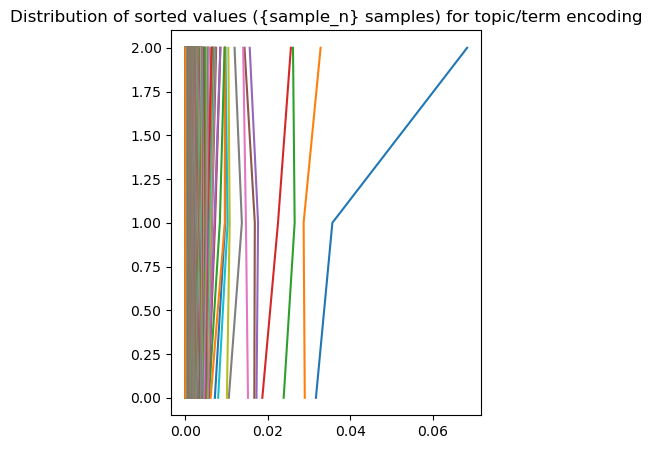

In [36]:
## term エンコード値の分布を確認

import matplotlib.pyplot as plt

plt.figure(figsize = (4,5))

sampling_rate = 0.3
df_size = len(topic_dist)
sample_n = round(df_size * sampling_rate)
topic_sampled = random.sample(list(topic_dist), sample_n)

T = sorted([ sorted(x, reverse = True) for x in topic_sampled ])

plt.plot(T, range(len(T)))
plt.title("Distribution of sorted values ({sample_n} samples) for topic/term encoding")
plt.show()

In [37]:
## tSNE を使った topics のグループ化 (3D)

from sklearn.manifold import TSNE
import numpy as np

## tSNE のパラメターを設定
## n_components は射影先の空間の次元: n_components = 3 なら3次元空間に射影
## perplexity は結合の強さを表わす指数で，値に拠って結果が代わるので，色々な値を試すと良い

#perplexity_val = 10 # 大き過ぎると良くない
top_perplexity_reduct_rate = 0.3
perplexity_val = round(len(topic_dist) * top_perplexity_reduct_rate)
topic_tSNE_3d = TSNE(n_components = 3, random_state = 0, perplexity = perplexity_val, n_iter = 1000)

## データに適用
top_tSNE_3d_fitted = topic_tSNE_3d.fit_transform(np.array(topic_dist))

/Users/kowk/opt/anaconda3/lib/python3.9/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [38]:
## Plotlyを使って tSNE の結果の可視化 (3D)

#import plotly.express as pex
import plotly.graph_objects as go
import numpy as np

top_tSNE = top_tSNE_3d_fitted
fig = go.Figure(data = [go.Scatter3d(x = top_tSNE[:,0], y = top_tSNE[:,1], z = top_tSNE[:,2],
                                     mode = 'markers')])

## 3D 散布図にラベルを追加する処理は未実装
title_val = f"3D tSNE view for LDA (#topics: {n_topics}, doc: {doc_type}, term: {term_type})"
fig.update_layout(autosize = False,
                  width = 600, height = 600, title = title_val)
fig.show()

/Users/kowk/opt/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/kowk/opt/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [39]:
## 構築した LDA モデルを使って文(書)を分類する

## .get_document_topics(..) は　minimu_probability = 0としないと
## topic の値が小さい場合に値を返さないので，

## パラメター

ntopics = n_topics # LDA の構築の最に指定した値を使う

check      = False
encoding = [ ]
for i, row in df.iterrows():
    if check:
        print(f"row: {row}")
    doc = row[doc_type]
    bot = row[term_type]
    ## get_document_topics(..) では　minimu_probability = 0 としないと
    ## 値が十分に大きな topics に関してだけ値が取れる
    enc = lda.get_document_topics(diction.doc2bow(bot), minimum_probability = 0)
    if check:
        print(f"enc: {enc}")
    encoding.append(enc)
#
len(encoding)

8652

In [40]:
## enc 列の追加

#df['enc'] = np.array(encoding) # This flattens arrays
#df['enc'] = list(encoding) # ineffective
df['enc'] = [ list(map(lambda x: x[1], y)) for y in encoding ]
if verbose:
    df['enc']

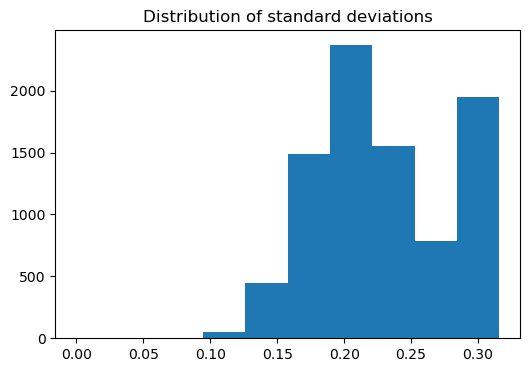

In [41]:
## エンコーディングのstd の分布を見る

from scipy.stats import tstd
from matplotlib import pyplot as plt

plt.figure(figsize = (6,4))

std_data = [ tstd(x) for x in df['enc'] ]
plt.hist(std_data)

plt.title("Distribution of standard deviations")
plt.show()

In [42]:
## doc のエンコーディング

## 一様分布の事例を除外

from scipy.stats import tstd # standard deviation の計算用

print(f"{len(df)} instances before filtering")

check = False

doc_enc = df['enc']
max_std = max([ tstd(x) for x in doc_enc])
if check: print(f"std max: {max_std}")

min_std = min([ tstd(x) for x in doc_enc])
if check: print(f"std min: {min_std}")

first_min_std = list(sorted(set([ tstd(x) for x in doc_enc])))[-0]
print(f"std 1st min: {first_min_std}")

second_min_std = list(sorted(set([ tstd(x) for x in doc_enc])))[-1]
print(f"std 2nd min: {second_min_std}")

8652 instances before filtering
std 1st min: 0.0
std 2nd min: 0.31571845569363965


In [43]:
## df_filtered の定義

## 閾値は2番目に小さい値より小さく最小値よりは大きな値であるべき
std_threshold = second_min_std / 4 # 穏健な値を得るために4で割った
print(f"std_threshold: {std_threshold}")

## Rっぽい次のコードは通らない
#df_filtered = df[ df['encoding'] > std_threshold ]

## 通るのは次のコード: Creating a list of True/False and apply it to DataFrame 
std_tested = [ False if tstd(x) < std_threshold else True for x in df['enc'] ]
df_filtered = df[ std_tested ]
#
print(f"{len(df_filtered)} instances after filtering ({len(df) - len(df_filtered)} instances removed)")

std_threshold: 0.07892961392340991
8651 instances after filtering (1 instances removed)


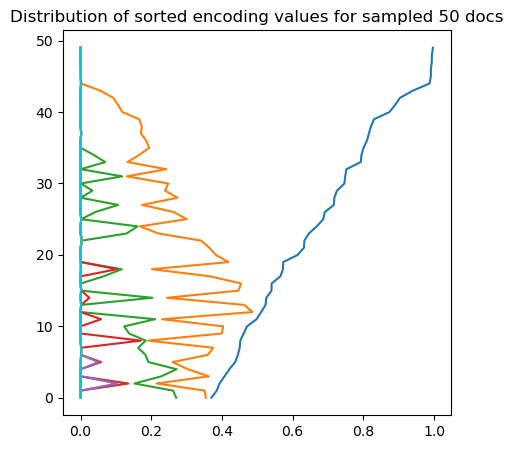

In [44]:
## doc エンコード値の分布を確認

sample_n = 50
E = sorted([ sorted(x, reverse = True) for x in df_filtered['enc'].sample(sample_n) ])

plt.figure(figsize = (5,5))
plt.plot(E, range(len(E)))
plt.title(f"Distribution of sorted encoding values for sampled {sample_n} docs")
plt.show()

In [45]:
len(df_filtered['language'])

8651

In [46]:
df_filtered['language'].value_counts

<bound method IndexOpsMixin.value_counts of 726        german
163        german
838        french
179     icelandic
732        arabic
          ...    
140        german
106        french
303        french
580        arabic
1850      english
Name: language, Length: 8651, dtype: object>

In [47]:
## tSNE 用の事例サンプリング = tSNE_df の定義

tSNE_sampling = True
tSNE_sampling_rate = 0.33
if tSNE_sampling:
    tSNE_df_original = df_filtered.copy()
    sample_n = round(len(tSNE_df_original) * tSNE_sampling_rate)
    tSNE_df = tSNE_df_original.sample(sample_n)
    print(f"tSNE_df has {len(tSNE_df)} rows after sampling")
else:
    tSNE_df = df_filtered

tSNE_df has 2855 rows after sampling


In [48]:
tSNE_df.columns

Index(['form', 'spell', 'sound', 'freq', 'arabic', 'bengali', 'chinese',
       'english', 'esperanto', 'finnish', 'french', 'greek', 'galician',
       'german', 'hungarian', 'icelandic', 'irish', 'italian', 'japanese',
       'russian', 'spanish', 'swahili', 'turkish', 'size', 'language', '1gram',
       '2gram', '3gram', 'skippy2gram', 'skippy3gram', 'enc'],
      dtype='object')

In [49]:
tSNE_df['language'].value_counts

<bound method IndexOpsMixin.value_counts of 1299    english
2894    english
141      german
482      german
618      french
         ...   
205     english
346      french
2481    english
792      arabic
190      arabic
Name: language, Length: 2855, dtype: object>

In [ ]:
## tSNE の結果の可視化: Plotly を使った 3D 描画

import numpy as np
from sklearn.manifold import TSNE as tSNE

import plotly.express as pex
import plotly.graph_objects as go
import matplotlib.pyplot as plt

## tSNE のパラメターを設定

perplexity_max_val = round(len(tSNE_df)/4)

for perplexity_val in range(5, perplexity_max_val, 60):
    
    ## tSNE 事例の生成
    tSNE_3d_varied = tSNE(n_components = 3, random_state = 0, perplexity = perplexity_val, n_iter = 1000)

    ## データに適用
    doc_enc = np.array(list(tSNE_df['enc']))
    doc_tSNE_3d_varied = tSNE_3d_varied.fit_transform(doc_enc)

    T = zip(doc_tSNE_3d_varied[:,0], doc_tSNE_3d_varied[:,1], doc_tSNE_3d_varied[:,2],
            tSNE_df['language']) # zip(..)が必要
    df = pd.DataFrame(T, columns = ['D1', 'D2', 'D3', 'language'])

    ## 作図
    fig = go.Figure()
    for lang in np.unique(df['language']):
        part = df[df['language'] == lang]
        fig.add_trace(
            go.Scatter3d(
                x = part['D1'], y = part['D2'], z = part['D3'],
                name = lang, mode = 'markers', marker = dict(size = 5),
                showlegend = True
            )
        )

    title_val = f"tSNE 3D map (ppl: {perplexity_val}) of '{doc_attr}'s encoded\n by LDA ({n_topics} topics, {term_type})"
    fig.update_layout(title = dict(text = title_val),
                      autosize = False, width = 600, height = 600,)
    fig.show()

/Users/kowk/opt/anaconda3/lib/python3.9/site-packages/plotly/express/imshow_utils.py:24: DeprecationWarning:

`np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)

/Users/kowk/opt/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/kowk/opt/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



/Users/kowk/opt/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/kowk/opt/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



/Users/kowk/opt/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/kowk/opt/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



/Users/kowk/opt/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/kowk/opt/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



/Users/kowk/opt/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/kowk/opt/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



/Users/kowk/opt/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/kowk/opt/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [ ]:
## 階層クラスタリングのための事例のサンプリング

hc_sampling_rate = 0.1 # 大きくし過ぎると図が見にくい
df_size = len(tSNE_df)
hc_sample_n = round(df_size * hc_sampling_rate)
hc_df = tSNE_df.sample(hc_sample_n)
##
print(f"{hc_sample_n} rows are sampled")
hc_df['language'].value_counts()

In [ ]:
## 日本語表示のための設定
#import matplotlib.pyplot as plt
#plt.rcParams["font.family"] = "Hiragino Sans" # Windows は別のフォント名を指定する必要がある
#plt.rcParams["font.family"] = "Lucida Sans Unicode"

In [ ]:
## doc 階層クラスタリングの実行

import numpy as np
import plotly
import matplotlib.pyplot as plt
## 次の設定は arabic が文字化けする
#plt.rcParams["font.family"] = "Hiragino Sans" # Windows は別のフォント名を指定する必要がある
#plt.rcParams["font.family"] = "Lucida Sans Unicode"

from scipy.cluster.hierarchy import dendrogram, linkage

## 距離行列の生成
Enc = list(hc_df['enc'])
linkage = linkage(Enc, method = 'ward', metric = 'euclidean')

## 描画サイズの指定
plt.figure(figsize = (5, round(len(hc_df) * 0.15))) # This needs to be run here, before dendrogram construction.

## 事例ラベルの生成
label_vals = [ x[:max_doc_size] for x in list(hc_df[doc_type]) ] # truncate doc keys

## 樹状分岐図の作成
dendrogram(linkage, orientation = 'left', labels = label_vals, leaf_font_size = 7)

## 描画
plt.title(f"Hierarchical clustering of (sampled) {len(hc_df)} (= {100 * hc_sampling_rate}%) {doc_attr}s as docs\n \
    encoded via LDA ({n_topics} topics) with {term_type} as terms")

## ラベルに language に対応する色を付ける
lang_colors = { lang_name : i for i, lang_name in enumerate(np.unique(hc_df['language'])) }
ax = plt.gca()
for ticker in ax.get_ymajorticklabels():
    form = ticker.get_text()
    row = hc_df.loc[hc_df[doc_type] == form]
    #lang = row['language']
    lang = row['language'].to_string().split()[-1] # trick
    try:
        lang_id = lang_colors[lang]
    except (TypeError, KeyError):
        print(f"color encoding error at: {lang}")
    #
    ticker.set_color(plotly.colors.qualitative.Plotly[lang_id]) # id の基数調整
#
plt.show()

In [ ]:
## tSNE の結果の可視化 (2D)

#import seaborn as sns
import numpy as np
import plotly
import plotly.express as pex
import matplotlib.pyplot as plt
from adjustText import adjust_text

## tSNE 事例の生成
perplexity_selected = 250
tSNE_3d = tSNE(n_components = 3, random_state = 0, perplexity = perplexity_selected, n_iter = 1000)

## データに適用
doc_enc = np.array(list(tSNE_df['enc']))
doc_tSNE_3d = tSNE_3d.fit_transform(doc_enc)

T = zip(doc_tSNE_3d[:,0], doc_tSNE_3d[:,1], doc_tSNE_3d[:,2],
        tSNE_df['language']) # zip(..)が必要
df = pd.DataFrame(T, columns = ['D1', 'D2', 'D3', 'language'])

## 描画
## 次の設定は arabic が文字化けする
#plt.rcParams["font.family"] = "Hiragino Sans" # Windows は別のフォント名を指定する必要がある
#plt.rcParams["font.family"] = "Lucida Sans Unicode"
plt.figure(figsize = (5, 5))
plt.set_colors = pex.colors.qualitative.Plotly
    
for r in [ np.roll([0,1,2], -i) for i in range(0,3) ]:
    if check:
        print(r)
    X, Y = df.iloc[:,r[0]], df.iloc[:,r[1]]
    gmax = max(X.max(), Y.max())
    gmin = min(X.min(), Y.min())
    plt.xlim(gmin, gmax)
    plt.ylim(gmin, gmax)

    colormap = pex.colors.qualitative.Plotly
    lang_list = list(np.unique(tSNE_df['language']))
    cmapped = [ colormap[lang_list.index(lang)] for lang in df['language'] ]
    scatter = plt.scatter(X, Y, s = 40, c = cmapped, edgecolors = 'w')

    ## 文字を表示する事例のサンプリング
    lab_sampling_rate = 0.02
    lab_sample_n = round(len(tSNE_df) * lab_sampling_rate)
    sampled_keys = [ doc[:max_doc_size] for doc in random.sample(list(tSNE_df[doc_type]), lab_sample_n) ]

    ## labels の生成
    texts = [ ]
    for x, y, s in zip(X, Y, sampled_keys):
        texts.append(plt.text(x, y, s, size = 9, color = 'blue'))

    ## label に repel を追加: adjustText package の導入が必要
    adjust_text(texts, force_points = 0.2, force_text = 0.2,
                expand_points = (1, 1), expand_text = (1, 1),
                arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))
    #

    plt.title(f"tSNE (ppl: {perplexity_selected}) 2D map of {len(tSNE_df)} {doc_attr}s via LDA ({term_type}; {n_topics} topics)")
    #plt.legend(np.unique(cmapped))
    plt.show()